In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.losses import mean_absolute_error

from lib import LSTM_model

Using TensorFlow backend.


In [2]:
plt.ion()
plt.style.use('seaborn-darkgrid')

In [3]:
plt.rcParams["figure.figsize"] = (18,9)
plt.rcParams['lines.linewidth'] = 1

The data about the bitcoin price is available from two different sources: Bitstamp and Coinbase. While the former is larger in terms of timesteps, it also has more NaN values thus making it less suitable for the task given that the bitcoin market had less activity in that time range.

In [4]:
bs_df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv')

### Data adjustments

Having a glance over the data we can see that it shows stock market information (Close, Open, Volume.. values) of bitcoin at each minute. NaN values indicate that there was no activity (therefore we assume the prices remain the last valid value seen) during that minute while missing timestamps means that the data for that minute is missing therefore we decide to interpolate it

In [5]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv',
                 dtype={
                     'Timestamp': np.int64,
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64,
                     'Volume_(BTC)': np.float64,
                     'Volume_(Currency)': np.float64,
                     'Weighted_Price': np.float64
                 }).sort_values(by=['Timestamp'])

df['Open'].fillna(inplace=True, method='ffill')
df['Close'].fillna(inplace=True, method='ffill')
df['High'].fillna(inplace=True, method='ffill')
df['Low'].fillna(inplace=True, method='ffill')
df['Volume_(BTC)'].fillna(0, inplace=True)
df['Volume_(Currency)'].fillna(0, inplace=True)

In the following steps we ensure that data is truly present at each minute from 2014-12-01 to 2018-11-11 and then we interpolate 

In [6]:
df = df.set_index('Timestamp')

# Ensure that there exists an instance for each minute
df = df.reindex(range(df.index[0], df.index[-1], 60), fill_value=np.nan)

df.reset_index(level=0, inplace=True)

df['Timestamp'] = df['Timestamp'].apply(lambda t: datetime.utcfromtimestamp(t))

### First 20 instances after the interpolation

In [7]:
df.interpolate(inplace=True)
df.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.000000
1,2014-12-01 05:34:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
2,2014-12-01 05:35:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
3,2014-12-01 05:36:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
4,2014-12-01 05:37:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
5,2014-12-01 05:38:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
6,2014-12-01 05:39:00,300.0,300.0,300.0,300.0,0.00,0.0,300.000000
7,2014-12-01 05:40:00,300.0,300.0,300.0,300.0,0.01,3.0,300.000000
8,2014-12-01 05:41:00,300.0,300.0,300.0,300.0,0.00,0.0,301.590909
9,2014-12-01 05:42:00,300.0,300.0,300.0,300.0,0.00,0.0,303.181818


Number of instances

In [8]:
len(df)

2074707

Text(0, 0.5, 'Mean Price ($)')

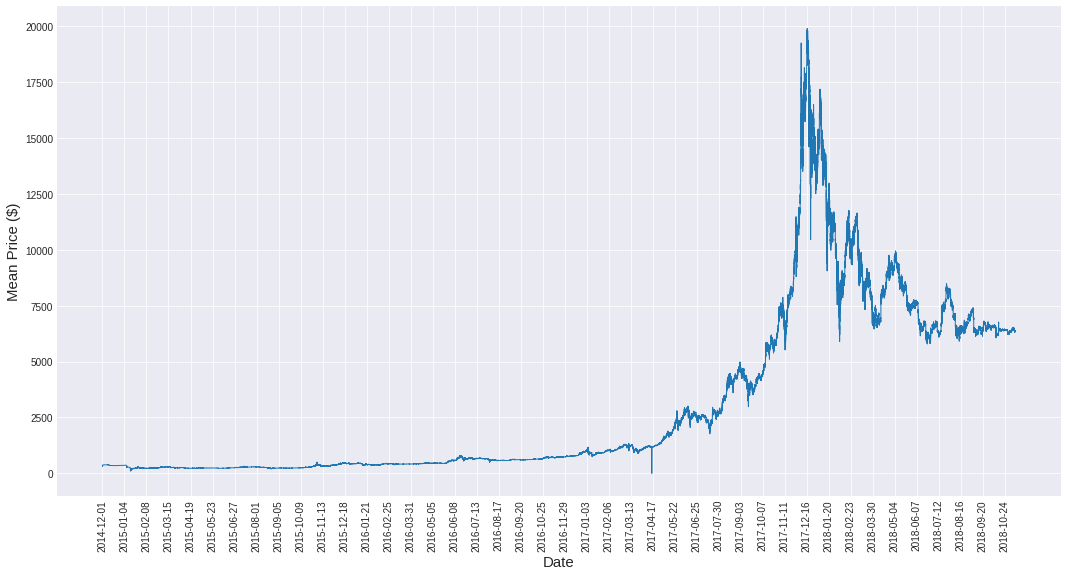

In [9]:
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
ts = df['Timestamp'].tolist()[::50000]
xticks = (t.strftime('%Y-%m-%d') for t in ts)
plt.xticks(range(0,df.shape[0],50000),xticks,rotation=90)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean Price ($)',fontsize=15)

## Observations

### Evaluating Time Series Forecasting

In time series forecasting we have to choose the input and the output of the model. We can choose for example to predict $x_{t + 1}$ at a given time $t$ by giving in input to the model $x_t$ or giving in input $(x_{t-k}, x_{t - k + 1},...,x_{t})$ where $k$ is the window size, i.e. how much of the past the predictor can observe. Both cases are called *One-Step Ahead* Forecasting.

This can be useful in some cases, such as weather forecasting. In the case of trading though, we would like to predict far in the future. This can be done by iteratively letting the model predict the next values based *not* on the actual values of the window but on the previously predicted values i.e. given in input $(\hat x_{t-k}, \hat x_{t - k + 1},..., \hat x_{t})$. This method might not work well if the model is trained in a one-step ahead fashion.

We must be careful on how we evaluate our model since what can happen is that we feed the network the actual data $(x_{t-k}, x_{t - k + 1},...,x_{t})$ for multiple values of $t$ producing the predicted values $\hat x_{t+1} \approx x_t, \hat x_{t+2} \approx x_{t+1}, \hat x_{t+3} \approx x_{t+2}, \hat x_{t+4} \approx x_{t+3}$ (similar to the *Persistence Model*) which produces a good result in terms of *Mean Absolute Error* (since the data has some inertia in fluctuatng) but not really useful given that at each timestep the model can see the previous *actual* data and thus does not depend by previous wrong predictions.

![lag](images/lag.png)

Alternatively we can perform a *Multi Step* Forecast i.e. letting the model predict the next $m$ values $x_{t+1}, ..., x_{t+m}$

### Data Preprocessing

Another issue we must consider is how to preprocess the data. We cannot normalize it over the full time period since given the spike of the BTC price in December 2017 a good portion of the data would be normalized close to 0.

A good way would be to normalize the data in the time window, i.e. by representing each datapoint in the window as a ratio (positive or negative) of increase/decrease in value with respect to the first data point of the window. In this case the data points will be values in the range $[-1, 1]$ (for appropriates values of the window size and if the data is not too volatile) thus a good activation function would be $tanh$.

Another way can be differencing the data which means mapping point $x_t$ to $x_t' = x_t - x_{t-1}$ and then normalize.

The windows can either overlap or not.

## Map Data to Day granularity

Given that the change of the values at the granularity of the minute is very small, we decide to group the data by day. We perform both 1 step ahead prediction and 5 steps ahead.

In [10]:
df['Date'] = df['Timestamp'].apply(lambda t: t.date())
daily_info = df.groupby('Date').agg({
    'Open': lambda opens: opens.iloc[0],     # Opening value of the day
    'Close': lambda closes: closes.iloc[-1], # Closing value of the day
    'Low' : np.min,                          # Lowest value of the day
    'High': np.max,                          # Highest value of the day
    'Volume_(BTC)': np.sum                   # Sum of the volumes of the minutes in the day
}).reset_index(level=0)
daily_info['Mean'] = (daily_info['High'] + daily_info['Close']) / 2
daily_info.head(20)

,Date,Open,Close,Low,High,Volume_(BTC),Mean
0,2014-12-01,300.000000,370.000000,300.000000,370.000000,0.056556,370.000000
1,2014-12-02,370.000000,378.000000,370.000000,378.000000,15.013600,378.000000
2,2014-12-03,378.000000,378.000000,377.010000,378.000000,0.546608,378.000000
3,2014-12-04,378.000000,377.516951,377.100000,378.000000,14.862718,377.758475
4,2014-12-05,377.517264,377.968047,377.517264,377.968047,19.541246,377.968047
5,2014-12-06,377.968361,377.026909,377.026909,378.000000,69.366556,377.513455
6,2014-12-07,377.029428,375.979636,375.979636,377.029428,179.692800,376.504532
7,2014-12-08,375.985646,376.261203,375.000000,376.270654,289.471801,376.265929
8,2014-12-09,376.284210,395.789505,376.274764,395.790466,182.990802,395.789985
9,2014-12-10,395.804021,368.564913,360.500000,398.000000,27.285516,383.282456


In [11]:
len(daily_info) # Number of days for which data is present or interpolated

1441

## Model

### Transform each window

Each window is "normalized" thus representing each value as percentage in increase or decrease of the first value in the window

$$
    \mathbf{w}' = \frac{\mathbf{w}}{w_0} - 1
$$

<img src="images/lstm.png" width="50%">

In [ ]:
IN_TIMESTEPS  = 15
OUT_TIMESTEPS = 1
TRAIN_RATIO = 0.7
X_cols = ["Open", "Close", "Mean"]
Y_cols = ["Mean"]

EPOCHS = 10**3
BATCH_SZ = 256

In [ ]:
def build_lstm_nn(timesteps, out_size, input_shape):
    return Sequential([
        LSTM(
            out_size,
            input_shape=(timesteps, input_shape))
    ])

In [ ]:
model = LSTM_model(
    in_timesteps=IN_TIMESTEPS, out_timesteps=OUT_TIMESTEPS,
    x_cols=X_cols, y_cols=Y_cols, step_col="Date", train_ratio=TRAIN_RATIO, model = build_lstm_nn
).data(daily_info).fit(epochs=EPOCHS)

In [ ]:
time, pred, true = model.get_pred_test_pair()
plt.plot(time, true, label='true')
plt.plot(time, model.orig_test[0][:,-1,2], label=str(OUT_TIMESTEPS) + '-lag')
plt.plot(time, pred, label='predicted')
plt.legend(loc='upper right', frameon=False)
print(f'LSTM test MAE: {model.get_test_mae()},  LAG test MAE: {np.abs(model.orig_test[0][:,-1,2] - true).mean()}')
print(f'LSTM train MAE: {model.get_train_mae()}')

As we can see the model is good in one step ahead prediction

### 4 Steps Ahead prediction

In [ ]:
OUT_TIMESTEPS = 4

model = LSTM_model(
    in_timesteps=IN_TIMESTEPS, out_timesteps=OUT_TIMESTEPS,
    x_cols=X_cols, y_cols=Y_cols, step_col="Date", train_ratio=TRAIN_RATIO, model = build_lstm_nn
).data(daily_info).fit(epochs=EPOCHS)

In [ ]:
time, pred, true = model.get_pred_test_pair()
lag = model.orig_test[0][:,-OUT_TIMESTEPS::OUT_TIMESTEPS,-1].reshape(-1)
plt.plot(time, true, label='true')
plt.plot(time[:-1], lag, label=str(OUT_TIMESTEPS) + '-lag')
plt.plot(time, pred, label='predicted')
plt.legend(loc='upper right', frameon=False)
print(f'LSTM test MAE: {model.get_test_mae()},  LAG test MAE: {np.abs(lag - true[:-1]).mean()}')
print(f'LSTM train MAE: {model.get_train_mae()}')

## DQN Trader

In [12]:
import dqn

In [13]:
train_days = daily_info.loc[daily_info['Date'] < datetime(2018, 1, 1).date()]
test_days = daily_info.loc[daily_info['Date'] >= datetime(2018, 1, 1).date()]

In [14]:
BUDGET = 10_000 # dollarz
WINDOW = 15
EPISODES = 4
BATCH_SZ = 64

btc_env = dqn.BitcoinStockEnvironment(train_days['Mean'].values, BUDGET, WINDOW)
trader_agent = dqn.DQNAgent(WINDOW, 2)

In [15]:
def plt_choices(days, results):
    x = np.array(range(len(days)))
    plt.plot(x, days)
    bought_x = x[results == 0]
    bought = days[results == 0]
    sold_x = x[results ==  1]
    sold = days[results == 1]
    plt.plot(bought_x, bought, 'g^')
    plt.plot(sold_x, sold, 'rv')
    plt.show()
    
def test_trader(trader_agent, btc_env):
    old_state = trader_agent.training
    trader_agent.training = False
    actions = []
    btcs = []
    budget = []
    rewards = []
    done = False
    state = btc_env.reset().reshape((1, WINDOW + 2))
    while not done:
        action = trader_agent.act(state)
        next_state, reward, done = btc_env.step(action)
        next_state = next_state.reshape((1, WINDOW + 2))
        state = next_state
        actions.append(action)
        budget.append(btc_env.budget)
        btcs.append(btc_env.btc)
        rewards.append(reward)

    trader_agent.training = old_state
    return actions, rewards, btcs, budget



In [17]:
for e in range(EPISODES):
    print(f"Episode: {e}")
    state = btc_env.reset().reshape((1, WINDOW + 2))
    actions = []
    for d in range(len(train_days)):
        action = trader_agent.act(state)
        next_state, reward, done = btc_env.step(action)
        next_state = next_state.reshape((1, WINDOW + 2))
        trader_agent.remember(state, action, reward, next_state, done)
        state = next_state
        actions.append(action)

        if d % 100 == 0:
            print(f"Btc: {btc_env.btc}")
            print(f"Budget: {btc_env.budget}")
        if done:
            break
        if len(trader_agent.memory) > 64:
            trader_agent.replay(BATCH_SZ)
    
    plt_choices(train_days['Mean'].values[WINDOW:], np.array(actions))
    actions, rewards, btcs, budget = test_trader(trader_agent, btc_env)
    plt_choices(train_days['Mean'].values[WINDOW:], np.array(actions))

Episode: 0
Btc: 0
Budget: 10000
Btc: 0.0
Budget: 9765.557064755241
Btc: 0.0
Budget: 9733.144564755243
Btc: 0.0
Budget: 9736.349564755243
Btc: 0.0
Budget: 9736.349564755243
Btc: 0.0
Budget: 9739.292064755242
Btc: 0.0
Budget: 9739.292064755242
Btc: 0.0
Budget: 9739.292064755242
Btc: 0.0
Budget: 9739.292064755242


KeyboardInterrupt: 

In [ ]:
btc_test_env = dqn.BitcoinStockEnvironment(test_days['Mean'].values, BUDGET, WINDOW)
actions, rewards, btcs, budget = test_trader(trader_agent, btc_test_env)
plt_choices(test_days['Mean'].values[WINDOW:], np.array(actions))
rewards

In [ ]:
btc_test_env.current_liquidity

In [ ]:
btc_env.norm_windows.reshape((btc_env.norm_windows.shape[0], btc_env.norm_windows.shape[1], 1)).shape

In [ ]:
len(results), len(train_days['Mean'][WINDOW:].values)
#len(list(filter(lambda r: r == 0, results)))

In [ ]:
plt_choices(train_days['Mean'][WINDOW:].values, np.array(results))